In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import MinMaxScaler

from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

import torch
from scipy.special import softmax

from torch.utils.data import DataLoader
import scipy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import copy
from torch.utils.data import Dataset, DataLoader

In [ ]:
def print_metrics(y_true, y_pred, y_prob):
    print("\n📌 Classification Report:")
    print(classification_report(y_true, y_pred))
    print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"✅ Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"✅ Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"✅ F1-score: {f1_score(y_true, y_pred):.4f}")
    print(f"✅ ROC AUC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\n📌 Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

In [ ]:
loan_data_backup = pd.read_csv('/content/drive/MyDrive/fin_credit/loan_data_inputs_train.csv')

In [ ]:
loan_data = loan_data_backup.copy()
pd.options.display.max_columns = None
loan_data.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,emp_length_int,earliest_cr_line_date,mths_since_earliest_cr_line,term_int,issue_d_date,mths_since_issue_d,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,sub_grade:A4,sub_grade:A5,sub_grade:B1,sub_grade:B2,sub_grade:B3,sub_grade:B4,sub_grade:B5,sub_grade:C1,sub_grade:C2,sub_grade:C3,sub_grade:C4,sub_grade:C5,sub_grade:D1,sub_grade:D2,sub_grade:D3,sub_grade:D4,sub_grade:D5,sub_grade:E1,sub_grade:E2,sub_grade:E3,sub_grade:E4,sub_grade:E5,sub_grade:F1,sub_grade:F2,sub_grade:F3,sub_grade:F4,sub_grade:F5,sub_grade:G1,sub_grade:G2,sub_grade:G3,sub_grade:G4,sub_grade:G5,home_ownership:ANY,home_ownership:MORTGAGE,home_ownership:NONE,home_ownership:OTHER,home_ownership:OWN,home_ownership:RENT,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,loan_status:Charged Off,loan_status:Current,loan_status:Default,loan_status:Does not meet the credit policy. Status:Charged Off,loan_status:Does not meet the credit policy. Status:Fully Paid,loan_status:Fully Paid,loan_status:In Grace Period,loan_status:Late (16-30 days),loan_status:Late (31-120 days),purpose:car,purpose:credit_card,purpose:debt_consolidation,purpose:educational,purpose:home_improvement,purpose:house,purpose:major_purchase,purpose:medical,purpose:moving,purpose:other,purpose:renewable_energy,purpose:small_business,purpose:vacation,purpose:wedding,addr_state:AK,addr_state:AL,addr_state:AR,addr_state:AZ,addr_state:CA,addr_state:CO,addr_state:CT,addr_state:DC,addr_state:DE,addr_state:FL,addr_state:GA,addr_state:HI,addr_state:IA,addr_state:ID,addr_state:IL,addr_state:IN,addr_state:KS,addr_state:KY,addr_state:LA,addr_state:MA,addr_state:MD,addr_state:ME,addr_state:MI,addr_state:MN,addr_state:MO,addr_state:MS,addr_state:MT,addr_state:NC,addr_state:NE,addr_state:NH,addr_state:NJ,addr_state:NM,addr_state:NV,addr_state:NY,addr_state:OH,addr_state:OK,addr_state:OR,addr_state:PA,addr_state:RI,addr_state:SC,addr_state:SD,addr_state:TN,addr_state:TX,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,home_ownership:RENT_OTHER_NONE_ANY,addr_state:ND,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:OK_TN_MO_LA_MD_NC,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d_factor,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate_factor,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,funded_amnt_f

### preprocessing

In [ ]:
loan_data['emp_length_int'] = loan_data['emp_length'].str.replace('\+ years', '',regex=True)
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('< 1 year', str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].fillna('0')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' year', '')
loan_data['emp_length_int'] = pd.to_numeric(loan_data['emp_length_int'])


In [ ]:
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format = '%b-%y')
loan_data['mths_since_earliest_cr_line'] = (
    (pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']).dt.days / 30.44
).round()
loan_data['mths_since_earliest_cr_line'][loan_data['mths_since_earliest_cr_line'] < 0] = loan_data['mths_since_earliest_cr_line'].max()

<ipython-input-7-503666818867>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  loan_data['mths_since_earliest_cr_line'][loan_data['mths_since_earliest_cr_line'] < 0] = loan_data['mths_since_earliest_cr_line'].max()
<ipython-input-7-50366681

In [ ]:
loan_data['term_int'] = loan_data['term'].str.replace(' months', '')
loan_data['term_int'] = pd.to_numeric(loan_data['term'].str.replace(' months', ''))

In [ ]:
loan_data['issue_d_date'] = pd.to_datetime(loan_data['issue_d'], format = '%b-%y')


loan_data['mths_since_issue_d'] = (
    (pd.to_datetime('2017-12-01') - loan_data['issue_d_date']).dt.days / 30.44
).round()

In [ ]:
loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace=True)
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(), inplace=True)
loan_data['mths_since_earliest_cr_line'].fillna(0, inplace=True)
loan_data['acc_now_delinq'].fillna(0, inplace=True)
loan_data['total_acc'].fillna(0, inplace=True)
loan_data['pub_rec'].fillna(0, inplace=True)
loan_data['open_acc'].fillna(0, inplace=True)
loan_data['inq_last_6mths'].fillna(0, inplace=True)
loan_data['delinq_2yrs'].fillna(0, inplace=True)
loan_data['emp_length_int'].fillna(0, inplace=True)

loan_data['y'] = np.where(loan_data['loan_status'].isin(['Charged Off', 'Default',
                                                       'Does not meet the credit policy. Status:Charged Off',
                                                       'Late (31-120 days)']), 0, 1)

<ipython-input-10-d24b19fc27a8>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace=True)
<ipython-input-10-d24b19fc27a8>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

### data selection

In [ ]:
df = loan_data.loc[: , ['grade',
'home_ownership',
#'addr_state',
'verification_status',
'purpose',
'initial_list_status',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'int_rate',
'mths_since_earliest_cr_line',
'delinq_2yrs',
'inq_last_6mths',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim',
'annual_inc',
'dti',
'y'
]]

subgrade : 이미 grade 컬럼이 있고, 그 안에 너무 많은 범주가 있기 때문에 데이터 제거를 선택


address : 너무 많은 범주가 있음. 우선 데이터 제거. 이후제거보다 구간화를 통해 범주의 개수를 줄이는 것 시도 가능

### modeling

In [ ]:
df.head()

,grade,home_ownership,verification_status,purpose,initial_list_status,term_int,emp_length_int,mths_since_issue_d,int_rate,mths_since_earliest_cr_line,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,total_acc,acc_now_delinq,total_rev_hi_lim,annual_inc,dti,y
0,A,MORTGAGE,Source Verified,debt_consolidation,f,36,3,45.0,8.90,372.0,0.0,1.0,20.0,0.0,32.0,0.0,57000.0,77000.0,21.91,1
1,C,MORTGAGE,Not Verified,debt_consolidation,f,36,6,64.0,14.33,240.0,1.0,2.0,15.0,0.0,38.0,0.0,10000.0,112000.0,7.49,1
2,A,MORTGAGE,Verified,debt_consolidation,f,36,10,54.0,8.90,317.0,0.0,1.0,9.0,0.0,20.0,0.0,33300.0,84000.0,14.83,1
3,D,RENT,Source Verified,debt_consolidation,f,36,7,44.0,16.59,230.0,1.0,3.0,9.0,0.0,13.0,0.0,12500.0,43000.0,13.68,0
4,C,MORTGAGE,Verified,educational,f,36,5,101.0,12.84,233.0,0.0,1.0,14.0,0.0,30.0,0.0,8400.0,94000.0,22.54,0


In [ ]:
# onehotencoding
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

df_encoded[df_encoded.select_dtypes(bool).columns] = df_encoded.select_dtypes(bool).astype(int)

#### 1. TabNet

In [ ]:
def load_data(data=df, batch_size=64):
    df = df_encoded.copy()

    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(float)

    if df['y'].dtype != 'int':
        df['y'] = df['y'].astype(int)

    X = df.drop(columns=['y']).astype(float)
    y = df['y']

    numeric_features = X.select_dtypes(include=['number']).columns
    scaler = MinMaxScaler()
    X[numeric_features] = scaler.fit_transform(X[numeric_features])

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

    class BankDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.tensor(X.values, dtype=torch.float32)
            self.y = torch.tensor(y.values, dtype=torch.float32)

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    # Dataloader 생성
    train_dataset = BankDataset(X_train_sub, y_train_sub)
    val_dataset   = BankDataset(X_val, y_val)
    test_dataset  = BankDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_dim = X.shape[1]
    return train_loader, val_loader, test_loader, input_dim

In [ ]:
# MLPClassifier 모델 정의 함수
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Train 함수 정의
def train_model(model, train_loader, val_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).view(-1, 1)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation Loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device).view(-1, 1)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()

    return total_loss / len(train_loader), val_loss / len(val_loader)

# Evaluation 함수
def evaluate_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()
            all_preds.extend(preds.flatten())
            all_labels.extend(yb.numpy())
    return np.array(all_labels), np.array(all_preds)

# 학습곡선 시각화
def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title("Learning Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# 성능 출력 함수
def print_metrics(y_true, y_pred, y_prob):
    print("\n📌 Classification Report:")
    print(classification_report(y_true, y_pred))
    print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"✅ Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"✅ Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"✅ F1-score: {f1_score(y_true, y_pred):.4f}")
    print(f"✅ ROC AUC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\n📌 Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

[Epoch 1] Train Loss: 0.3339 | Val Loss: 0.3226
[Epoch 2] Train Loss: 0.3264 | Val Loss: 0.3225
[Epoch 3] Train Loss: 0.3254 | Val Loss: 0.3217
[Epoch 4] Train Loss: 0.3245 | Val Loss: 0.3211
[Epoch 5] Train Loss: 0.3241 | Val Loss: 0.3216
[Epoch 6] Train Loss: 0.3236 | Val Loss: 0.3211
[Epoch 7] Train Loss: 0.3236 | Val Loss: 0.3207
[Epoch 8] Train Loss: 0.3232 | Val Loss: 0.3208
[Epoch 9] Train Loss: 0.3233 | Val Loss: 0.3204
[Epoch 10] Train Loss: 0.3229 | Val Loss: 0.3205
[Epoch 11] Train Loss: 0.3229 | Val Loss: 0.3206
[Epoch 12] Train Loss: 0.3229 | Val Loss: 0.3213
[Epoch 13] Train Loss: 0.3229 | Val Loss: 0.3204
[Epoch 14] Train Loss: 0.3225 | Val Loss: 0.3208
[Epoch 15] Train Loss: 0.3227 | Val Loss: 0.3208
[Epoch 16] Train Loss: 0.3226 | Val Loss: 0.3208
[Epoch 17] Train Loss: 0.3225 | Val Loss: 0.3205
[Epoch 18] Train Loss: 0.3224 | Val Loss: 0.3211
[Epoch 19] Train Loss: 0.3224 | Val Loss: 0.3209
🛑 Early stopping triggered at epoch 19

✅ Best Model saved at epoch 9, Val Los

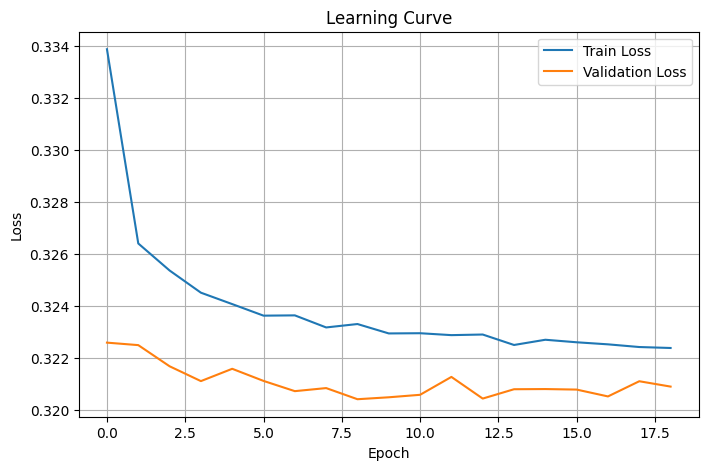

In [ ]:
num_epochs = 100
patience = 10
learning_rate = 0.001
batch_size = 64
model_path = "best_model.pth"

train_loader, val_loader, test_loader, input_dim = load_data(batch_size=batch_size)

# 모델/손실/옵티마이저 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPClassifier(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 학습 초기화
train_losses, val_losses = [], []
best_val_loss = float('inf')
best_epoch = 0
patience_counter = 0
best_weights = copy.deepcopy(model.state_dict())

# 모델 학습
for epoch in range(1, num_epochs + 1):
    train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_weights = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), model_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping triggered at epoch {epoch}")
            break

print(f"\n✅ Best Model saved at epoch {best_epoch}, Val Loss: {best_val_loss:.4f}")
plot_learning_curve(train_losses, val_losses)

In [ ]:
model.load_state_dict(torch.load(model_path))
y_true, y_prob = evaluate_model(model, test_loader, device)
y_pred = (y_prob >= 0.9).astype(int)
print_metrics(y_true, y_pred, y_prob)


📌 Classification Report:
              precision    recall  f1-score   support

         0.0       0.16      0.76      0.27      8156
         1.0       0.95      0.52      0.67     66450

    accuracy                           0.54     74606
   macro avg       0.55      0.64      0.47     74606
weighted avg       0.86      0.54      0.62     74606

✅ Accuracy: 0.5436
✅ Precision: 0.9466
✅ Recall: 0.5168
✅ F1-score: 0.6686
✅ ROC AUC: 0.6985

📌 Confusion Matrix:
[[ 6219  1937]
 [32110 34340]]
